,prop,other_resp,other_prop,time_spent_risk,cells,selfish,time_spent_prop,count_effort,Honesty_Humility,Extraversion,Agreeableness,min_offer
0,50,50,50,43000,26,60,31000,20,4.2,3.0,2.8,50
1,50,20,20,12000,7,20,38000,20,1.9,4.4,2.9,50
2,120,50,80,88000,50,20,69000,12,3.3,3.8,3.4,80
3,50,50,50,24000,50,60,26000,14,3.6,3.8,2.6,50
4,100,50,50,137000,24,60,43000,4,3.6,2.5,2.7,100


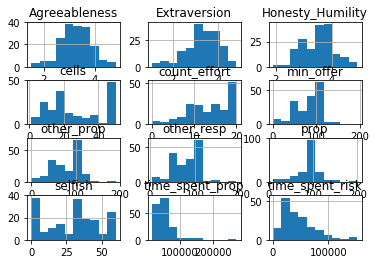

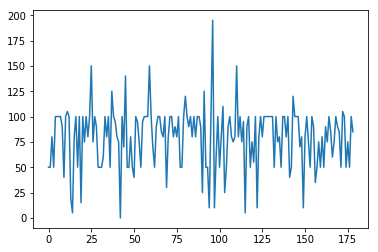

In [37]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sb

#fix rnd seed
np.random.seed(7)

# Read and sanitize the data
df = pd.read_excel("./UG_HH_NEW_continuous_no200.xls")
df = df.dropna()

#print(df[50:])

# Show head and histograms
display(df.head())
df.hist()

# Plot sample figure for min_offers
plt.figure()

x = range(0, len(df['prop']))
x1 = df['min_offer']

plt.plot(x, x1)

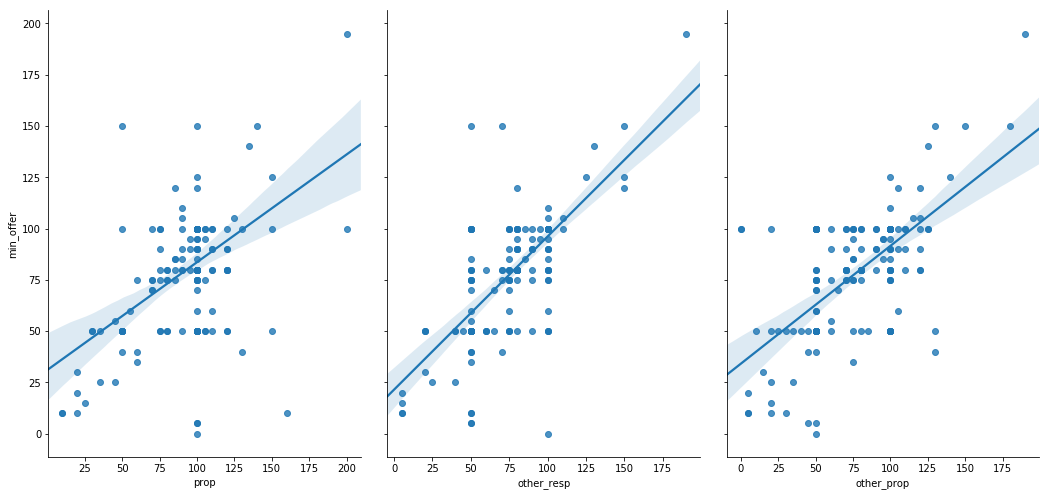

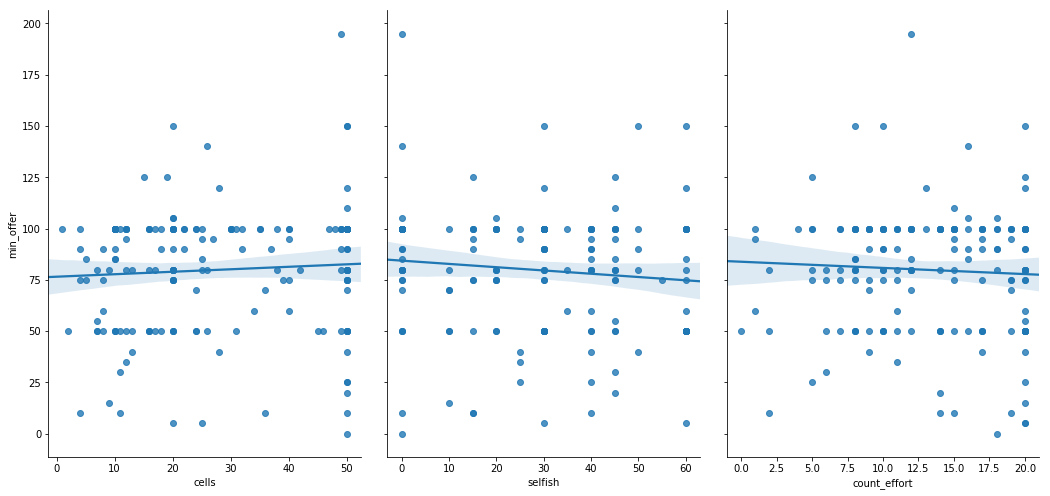

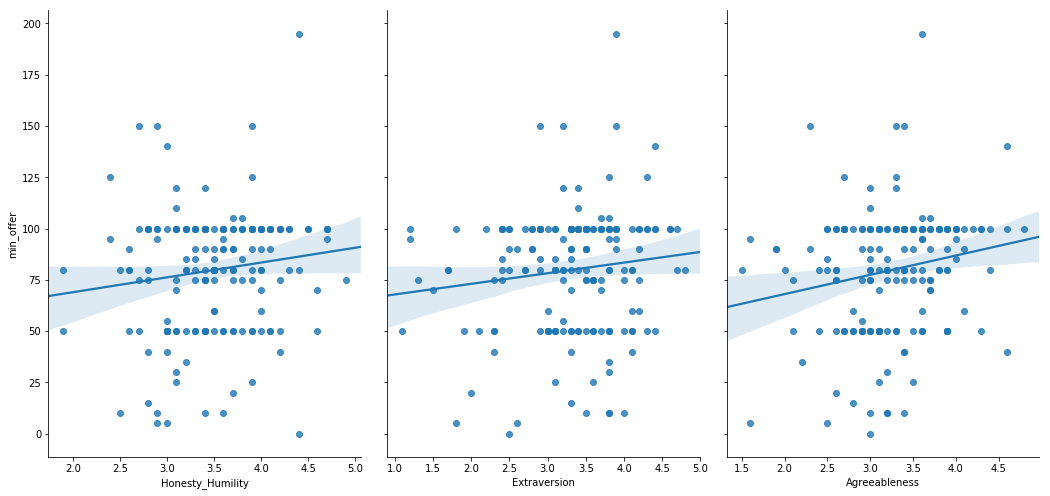

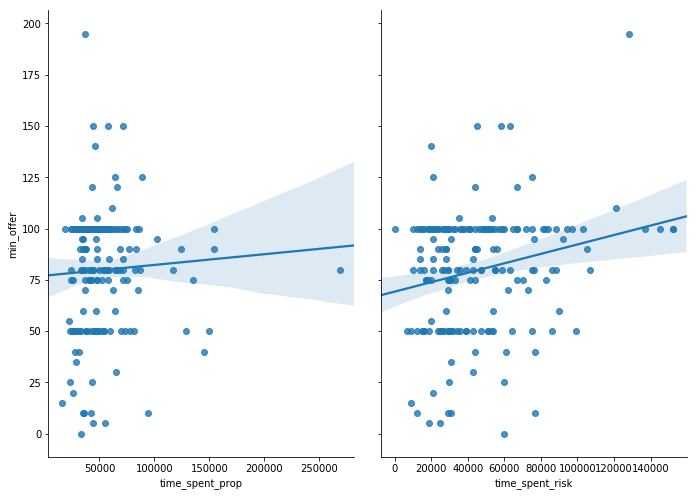

In [38]:
sb.pairplot(df, x_vars=('prop','other_resp','other_prop'), y_vars='min_offer', height=7, aspect=0.7, kind='reg')
sb.pairplot(df, x_vars=('cells', 'selfish','count_effort'), y_vars='min_offer', height=7, aspect=0.7, kind='reg')
sb.pairplot(df, x_vars=('Honesty_Humility', 'Extraversion','Agreeableness'), y_vars='min_offer', height=7, aspect=0.7, kind='reg')
sb.pairplot(df, x_vars=('time_spent_prop', 'time_spent_risk'), y_vars='min_offer', height=7, aspect=0.7, kind='reg')

In [39]:
#manual ablation
#df = df.drop(columns=['cells','selfish','count_effort','Honesty_Humility','Extraversion','Agreeableness','time_spent_risk','time_spent_prop'])

Intercept: [12.14795034]
Coef: [[-2.00585445e-02  4.83360086e-01  3.84727117e-01  9.83711395e-05
   1.26315032e-01 -3.59930595e-02 -1.64681964e-04 -3.20690818e-01
  -3.59917342e+00  2.18793249e+00  2.95923847e+00]]
R2: 0.4771808621980129


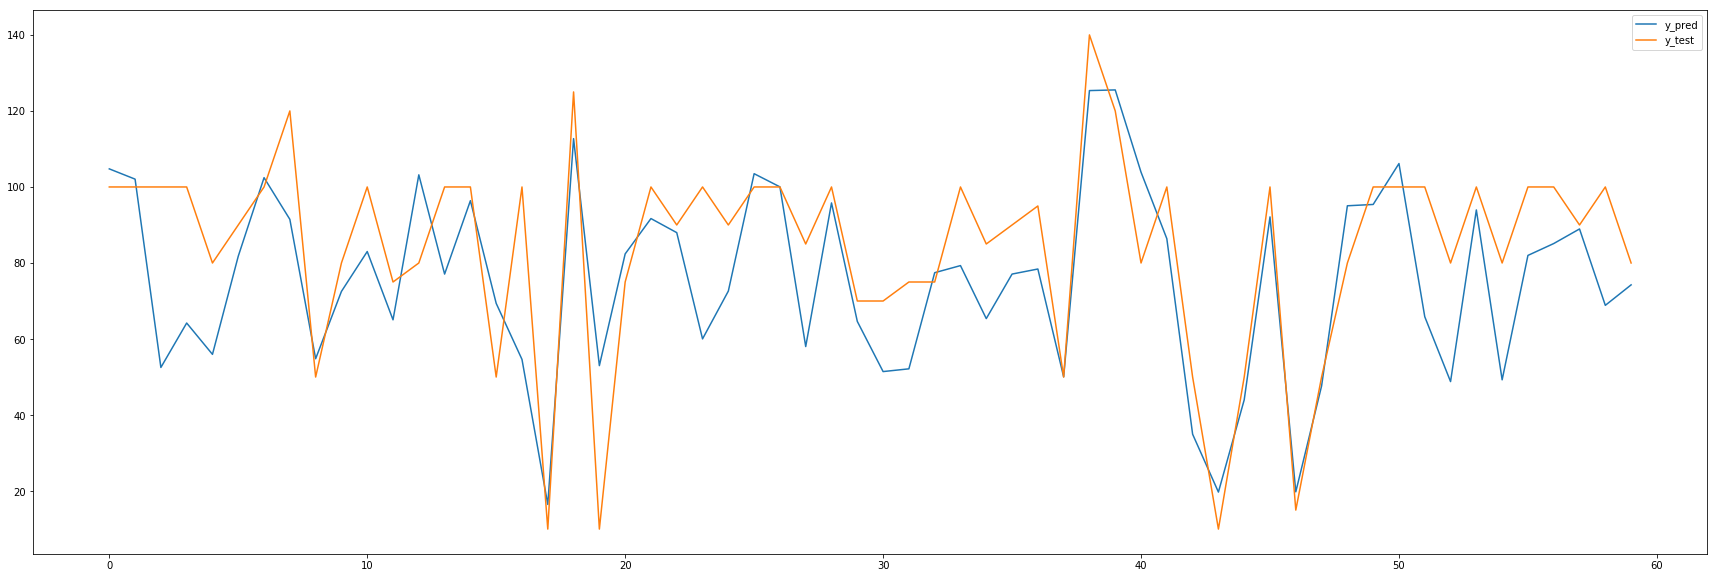

In [40]:
from sklearn.linear_model import LinearRegression
# Split into inputs and oututs
x = df.iloc[:, :-1].values

y = df.iloc[:, -1:].values
#print(x)
#print(y)

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 1/3, random_state = 0)
#print(xTrain)
#print(yTrain)

regressor = LinearRegression(copy_X=True).fit(xTrain, yTrain)

print("Intercept:", regressor.intercept_)
print("Coef:", regressor.coef_)

yPredict = regressor.predict(xTest)
print("R2:", r2_score(yTest, yPredict))

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPredict)})
#print(out_data)

out_data.plot(figsize=(30,10))

In [47]:
#keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import multiply
from keras.wrappers.scikit_learn import KerasRegressor
import keras.backend as K
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import tensorflow as tf
import sys
                    
def strict_gain(y_true, y_pred):
    #y_true = K.print_tensor(y_true,message='y_true:')
    #y_pred = K.print_tensor(y_pred,message='y_pred:')
    ge = K.greater_equal(y_pred, y_true)
    #ge = K.print_tensor(ge,message='ge:')
    sub = tf.math.subtract(y_pred, y_true)
    re = tf.where(ge, y_true, sub)
    #re = K.print_tensor(re,message='re:')
    #return K.abs(re)
    return K.square(re)


def simple_model():
    model = Sequential()
    model.add(Dense(11, input_dim=11, kernel_initializer='normal', activation='relu'))
    #model.add(Dense(11, activation='relu'))
    #output 
    model.add(Dense(1, kernel_initializer='normal'))
    #adam: sse 
    model.compile(loss=strict_gain, optimizer='rmsprop')
    #model.compile(loss="mse", optimizer='Adam')
    return model

Results: 218.46 (116.69) MSE, Scalar test loss: 7631.24


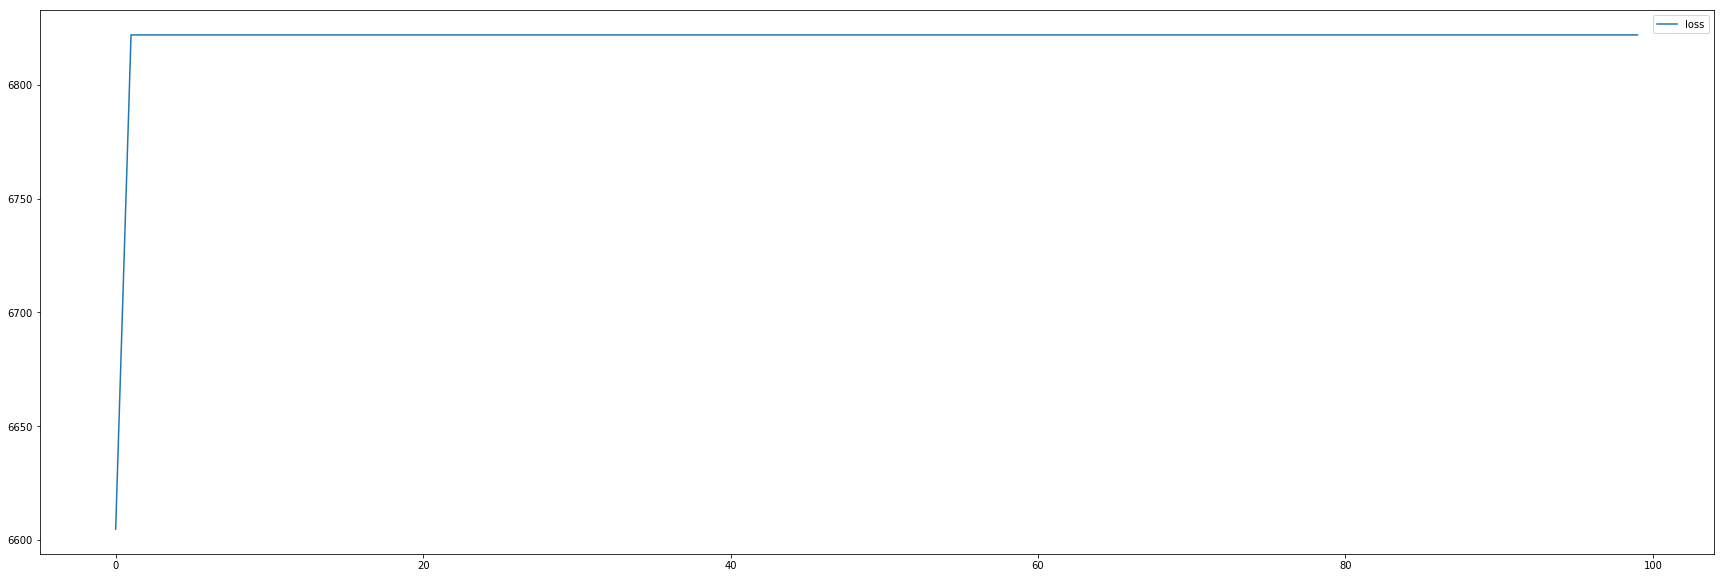

In [50]:
#sci-kit like training
sm = simple_model() 
history = sm.fit(xTrain, yTrain, validation_split=1/4, epochs=100, batch_size=8, verbose=0)
loss_hist = pd.DataFrame(data={'loss': history.history['loss']})
loss_hist.plot(figsize=(30,10))
smPredict = sm.predict(xTest, batch_size=128)

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(smPredict)})
stl = sm.evaluate(xTest, yTest, verbose=0)
print("Results: %2.2f (%.2f) MSE, Scalar test loss: %.2f" % (smPredict.mean(), smPredict.std(), stl))
#out_data.plot(figsize=(30,10))

In [49]:

yPredict = sm.predict(xTest)
print("R2:", r2_score(yTest, yPredict))

R2: -254.66387608414303


In [44]:
loss_baseline = "mse"
MAX_GAIN = 200.0

def gain(predicted, min_offer):
    res = MAX_GAIN - predicted
    res[predicted < min_offer] = 0
    return res

def gain_mean(predicted, min_offer):
    res = MAX_GAIN - predicted
    res[predicted < min_offer] = 0
    return res.sum() / res.shape[0]

In [45]:
gain_mean(yTest, yPredict)

1.6666666666666667

In [46]:
df.shape

(179, 12)